# Instrucciones para el Examen

## Objetivo

Este examen tiene como objetivo evaluar la capacidad del estudiante para limpiar, explorar, implementar y evaluar modelos de clasificación en un dataset de diabetes.  
Utilizaremos el “Diabetes Dataset” disponible en Kaggle.  
Los estudiantes deben demostrar habilidades prácticas en la manipulación de datos, creación de visualizaciones y modelado predictivo.

---

## Contexto y Descripción del Dataset

El “Diabetes Dataset” contiene datos de salud de mujeres de ascendencia indígena Pima que viven cerca de Phoenix, Arizona, EE.UU.  
La tarea es predecir si un paciente tiene diabetes o no, basándose en ciertas medidas diagnósticas incluidas en el dataset.

---

## Diccionario de Datos

- **Pregnancies**: Número de embarazos.  
- **Glucose**: Concentración de glucosa en plasma a las 2 horas en una prueba oral de tolerancia a la glucosa.  
- **BloodPressure**: Presión arterial diastólica (mm Hg).  
- **SkinThickness**: Espesor del pliegue cutáneo del tríceps (mm).  
- **Insulin**: Niveles séricos de insulina a las 2 horas (mu U/ml).  
- **BMI**: Índice de masa corporal (peso en kg / (altura en m)^2).  
- **DiabetesPedigreeFunction**: Función de pedigrí de diabetes.  
- **Age**: Edad (años).  
- **Outcome**: Variable objetivo (1: diabetes, 0: no diabetes).


In [ ]:
# Primeras librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para modelado
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Para evaluación de modelos
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix

In [ ]:
# Configuración para visualizaciones
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [ ]:
#FASE 1: CARGAR Y OBTENER INFORMACIÓN INICIAL

#Conectarse a archivos en Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cargar el dataset y pasarlo a un DataFrame
path = "/content/drive/MyDrive/Bootcamp Data Science/Machine Learning/BBDD/diabetes.csv"
df = pd.read_csv(path)

In [ ]:
#Información inicial básica
df.info()
print("\nTipos de datos verificados: Todas las columnas numéricas están en el formato correcto.")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB

Tipos de datos verificados: Todas las columnas numéricas están en el formato correcto.


In [ ]:
# Primeras filas y información general para una primera inspección
print("\nPrimeras 5 filas del dataset:")
print(df.head())


Primeras 5 filas del dataset:
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


In [ ]:
print("\nEstadísticas descriptivas iniciales:")
print(df.describe())


Estadísticas descriptivas iniciales:
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951

In [ ]:
# FASE 2: EDA (Analisis exploratorio de datos)

# Identificación y Eliminación de Valores Duplicados
print(f"\nNúmero de filas duplicadas antes de la eliminación: {df.duplicated().sum()}")
df.drop_duplicates(inplace=True)
print(f"Número de filas duplicadas después de la eliminación: {df.duplicated().sum()}")


Número de filas duplicadas antes de la eliminación: 0
Número de filas duplicadas después de la eliminación: 0


In [ ]:
#Verificar valores en la columna Outcome
df['Outcome'].value_counts()

,count
Outcome,
0,500
1,268


In [ ]:
#Columnas claves, revisión de valores extraños o ceros
cols_with_zeros_as_nan = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# Verificación de valores
print("\n--- Verificación de valores en columnas claves")
for col in cols_with_zeros_as_nan:
    if col in df.columns:
        zeros_count = (df[col] == 0).sum()
        if zeros_count > 0:
            print(f" - '{col}': Se encontraron {zeros_count} valores en 0.")
        else:
            print(f" - '{col}': No se encontraron valores en 0.")

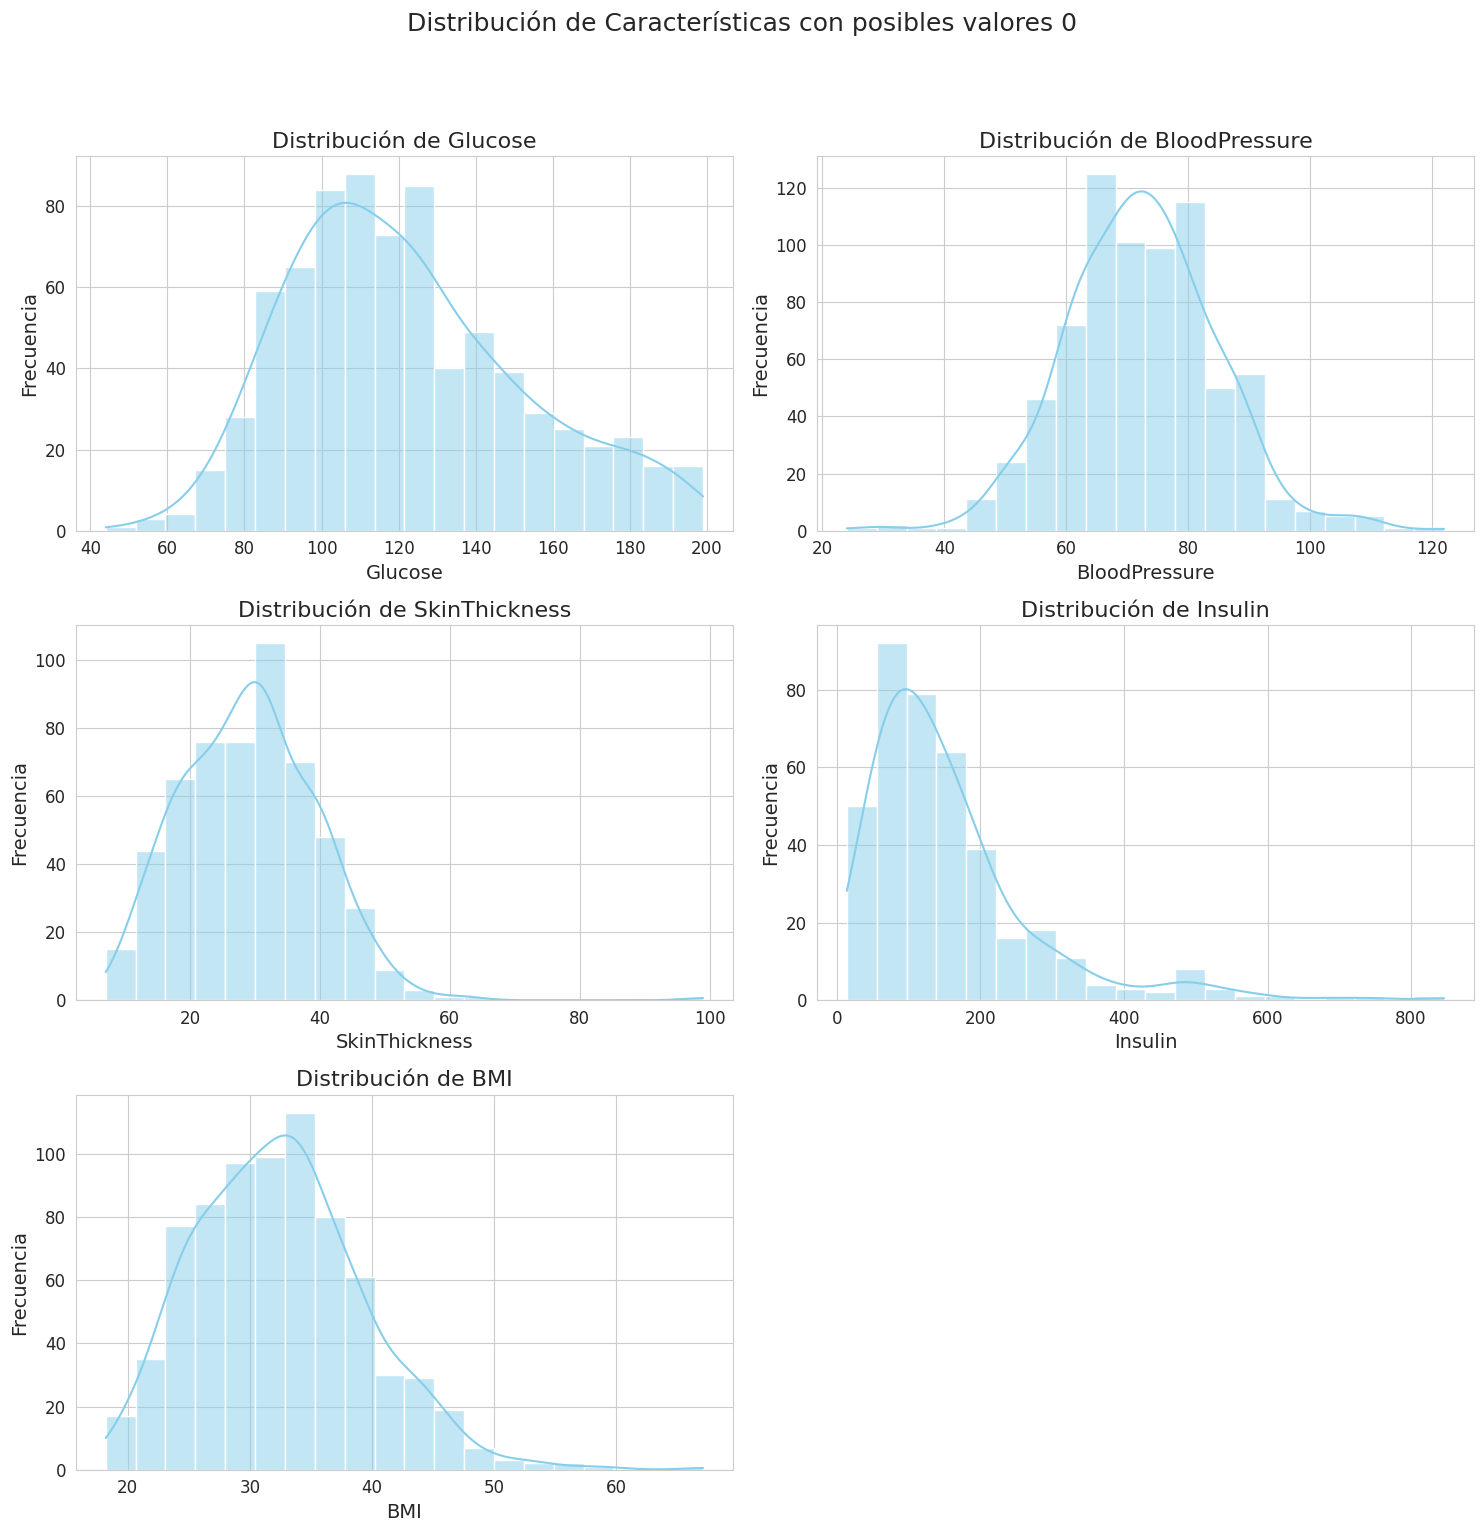

In [ ]:
#Visualización de columnas claves para entender su distribución en cada una

n_cols_plot = 2
n_rows_plot = (len(cols_with_zeros_as_nan) + n_cols_plot - 1) // n_cols_plot

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, n_rows_plot * 5))
axes = axes.flatten()

for i, col in enumerate(cols_with_zeros_as_nan):
    if col in df.columns:
        sns.histplot(df[col], bins=20, kde=True, color='skyblue', ax=axes[i])
        if (df[col] == 0).any():
            axes[i].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Ceros (valores anómalos)')
            axes[i].legend()
        axes[i].set_title(f'Distribución de {col}')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')

# Ocultar subplots vacíos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribución de Características con posibles valores 0', y=1.02, fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

**Se verificaron estas columnas ya que biológicamente es imposible que tengan valores extraños por ejemplo de texto o tener ceros, lo cual desde el lado médico es imposible.**

In [ ]:
# Reemplazar 0 por NaN en estas columnas
print("\nReemplazando valores 0 por NaN en columnas seleccionadas...")
for col in cols_with_zeros_as_nan:
    if col in df.columns:
        df[col] = df[col].replace(0, np.nan)

print("\nConteo de valores NaN después de reemplazar 0s:")
print(df.isnull().sum())


Reemplazando valores 0 por NaN en columnas seleccionadas...

Conteo de valores NaN después de reemplazar 0s:
Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64



--- Visualización de la distribución después de reemplazar 0s con NaN ---


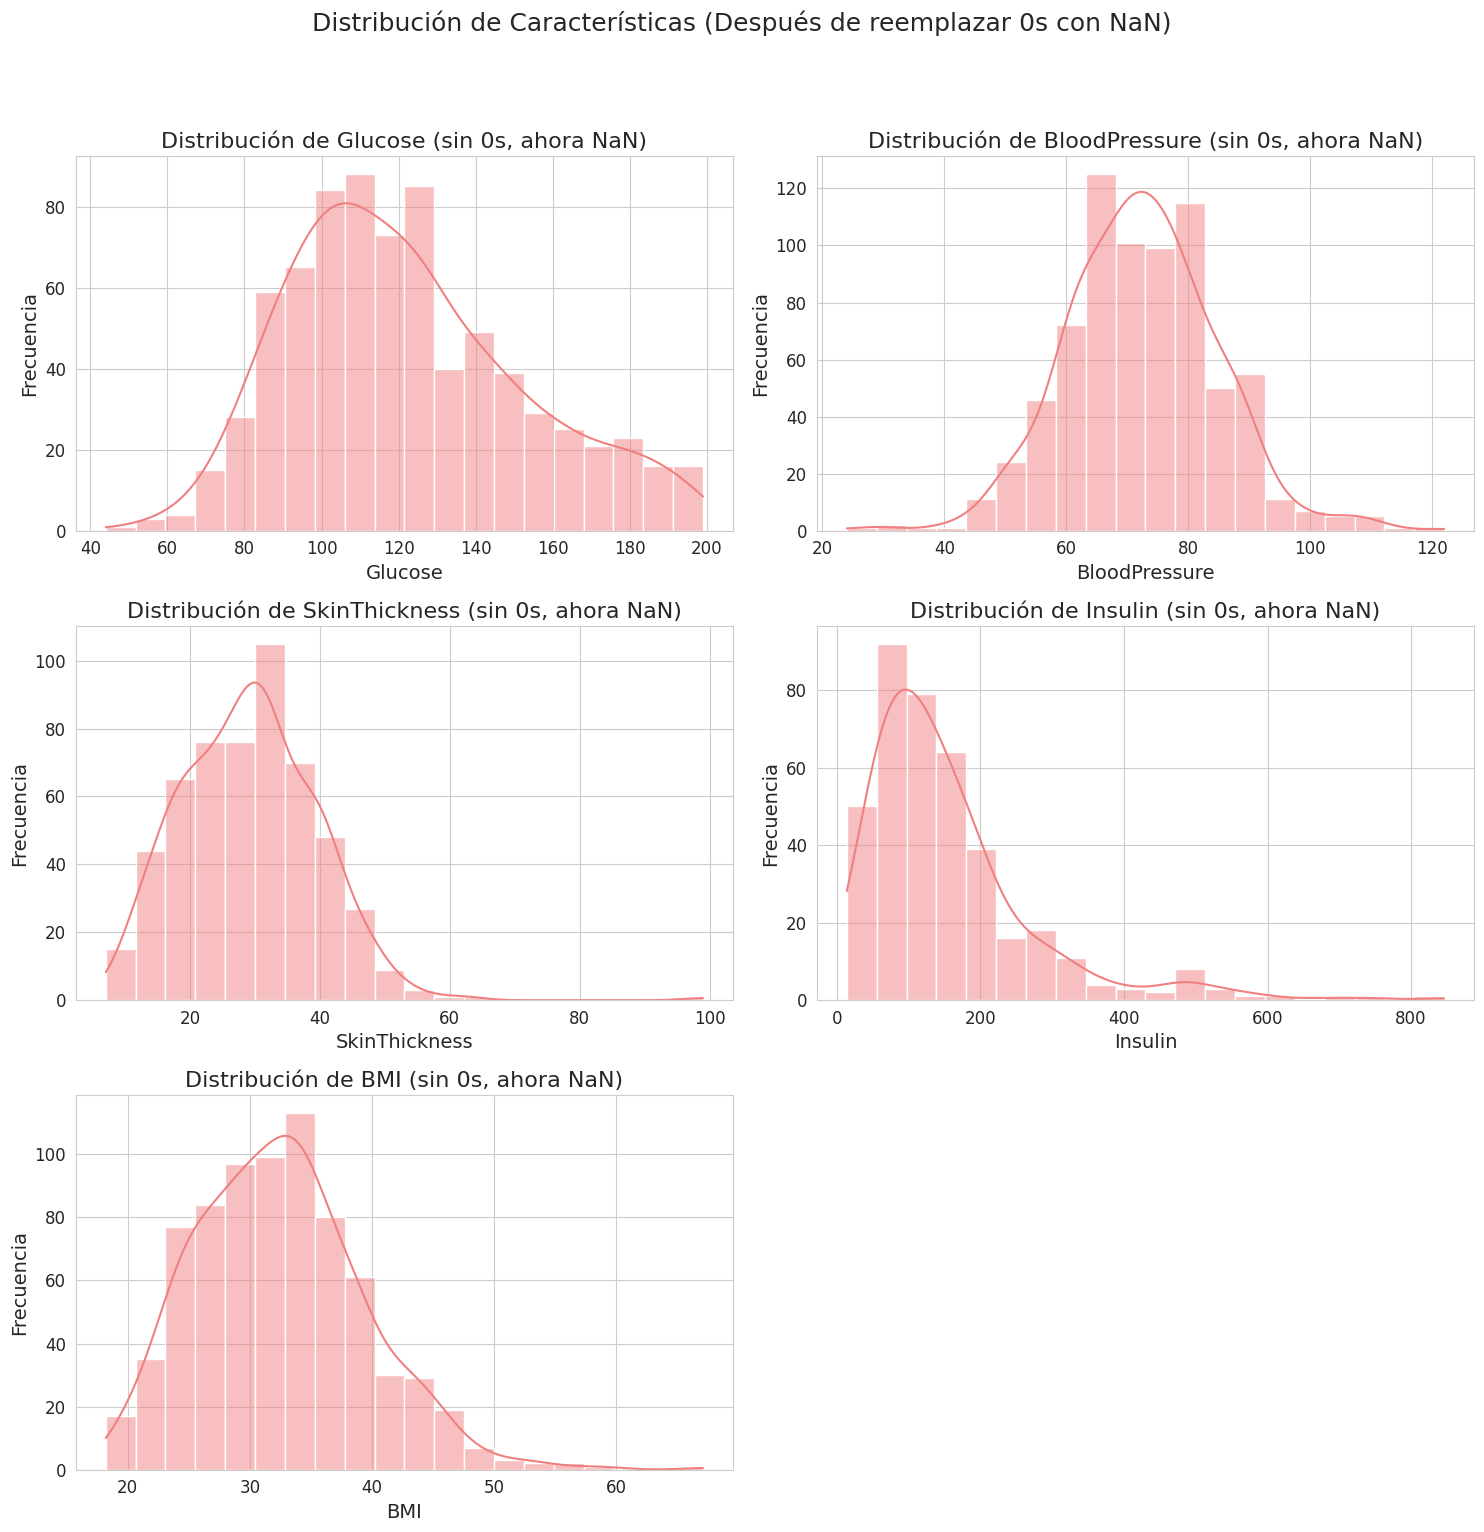

In [ ]:
# --- Visualización de la distribución después de reemplazar 0s con NaN (observar los huecos) ---
print("\n--- Visualización de la distribución después de reemplazar 0s con NaN ---")

fig, axes = plt.subplots(n_rows_plot, n_cols_plot, figsize=(15, n_rows_plot * 5))
axes = axes.flatten()

for i, col in enumerate(cols_with_zeros_as_nan):
    if col in df.columns:
        # Graficar solo los valores no NaN para ver la distribución "limpia"
        sns.histplot(df[col].dropna(), bins=20, kde=True, color='lightcoral', ax=axes[i])
        axes[i].set_title(f'Distribución de {col} (sin 0s, ahora NaN)')
        axes[i].set_xlabel(col)
        axes[i].set_ylabel('Frecuencia')

# Ocultar subplots vacíos
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.suptitle('Distribución de Características (Después de reemplazar 0s con NaN)', y=1.02, fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

In [ ]:
# Estrategia de imputación: Usando la Mediana.
print("\nImputando valores faltantes con la mediana de cada columna...")
for col in cols_with_zeros_as_nan:
    if df[col].isnull().any():
        median_val = df[col].median()
        df[col].fillna(median_val, inplace=True)
        print(f" - Columna '{col}' imputada con la mediana: {median_val:.2f}")

print("\nConteo de valores NaN después de la imputación:")
print(df.isnull().sum())
print("\nLimpieza de datos completada.")


Imputando valores faltantes con la mediana de cada columna...
 - Columna 'Glucose' imputada con la mediana: 117.00
 - Columna 'BloodPressure' imputada con la mediana: 72.00
 - Columna 'SkinThickness' imputada con la mediana: 29.00
 - Columna 'Insulin' imputada con la mediana: 125.00
 - Columna 'BMI' imputada con la mediana: 32.30

Conteo de valores NaN después de la imputación:
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

Limpieza de datos completada.


/tmp/ipython-input-31-1010047517.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(median_val, inplace=True)


In [ ]:
print("\nEstadísticas descriptivas completas del dataset (después de la limpieza):")
print(df.describe())


Estadísticas descriptivas completas del dataset (después de la limpieza):
       Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  121.656250      72.386719      29.108073  140.671875   
std       3.369578   30.438286      12.096642       8.791221   86.383060   
min       0.000000   44.000000      24.000000       7.000000   14.000000   
25%       1.000000   99.750000      64.000000      25.000000  121.500000   
50%       3.000000  117.000000      72.000000      29.000000  125.000000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    32.455208                  0.471876   33.240885    0.348958  
std      6.875177             

In [ ]:
print("\nModa para cada columna:")
for col in df.columns:
    if df[col].dtype != 'object':
        print(f"{col}: {df[col].mode()[0]}")


Moda para cada columna:
Pregnancies: 1
Glucose: 99.0
BloodPressure: 72.0
SkinThickness: 29.0
Insulin: 125.0
BMI: 32.3
DiabetesPedigreeFunction: 0.254
Age: 22
Outcome: 0



Generando histogramas de distribución para cada característica...


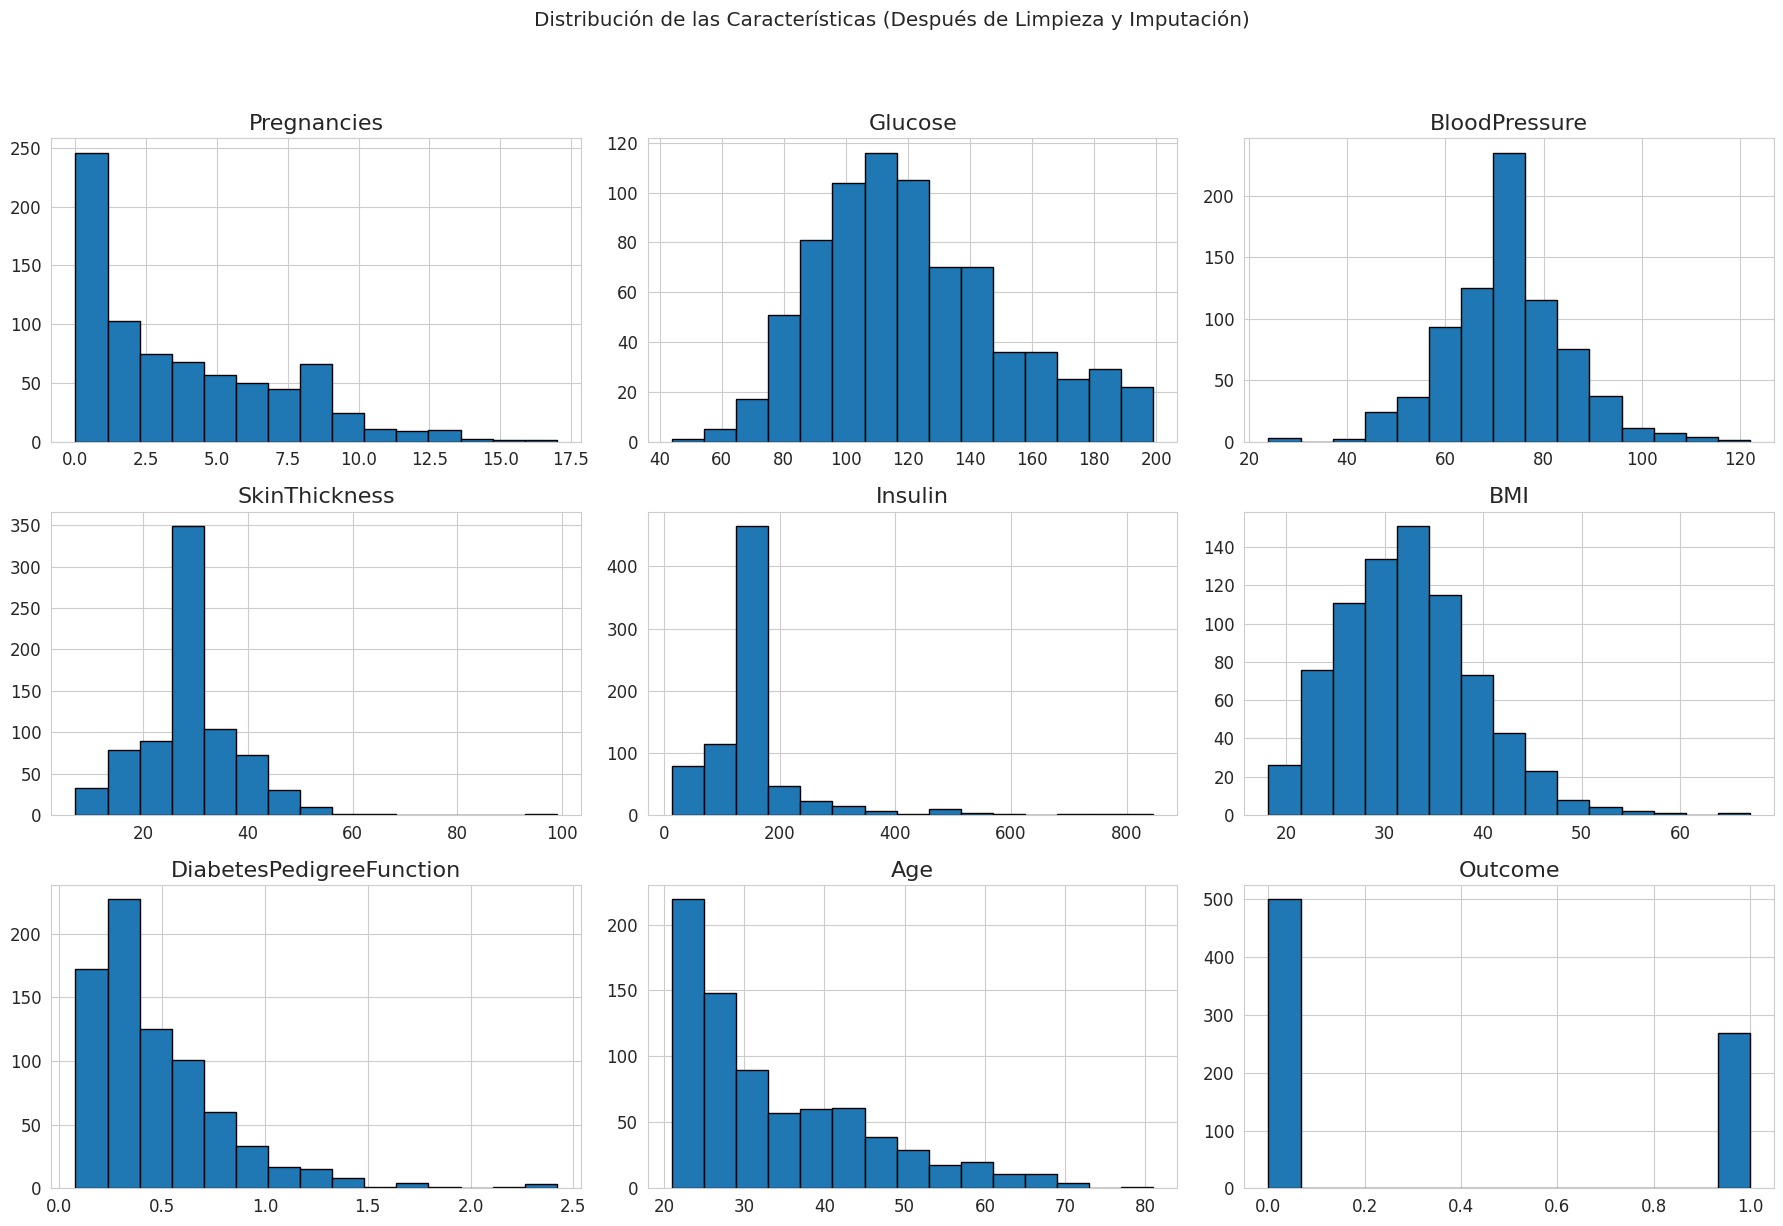

In [ ]:
#FASE 3: VISUALIZACIONES
# Histogramas de Distribución para todas las columnas numéricas
print("\nGenerando histogramas de distribución para cada característica...")
df.hist(bins=15, figsize=(18, 12), layout=(3, 3), edgecolor='black')
plt.suptitle('Distribución de las Características (Después de Limpieza y Imputación)', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()


Generando gráfico de barras para la distribución de la variable objetivo 'Outcome'...


/tmp/ipython-input-38-306691747.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Outcome', data=df, palette='viridis')


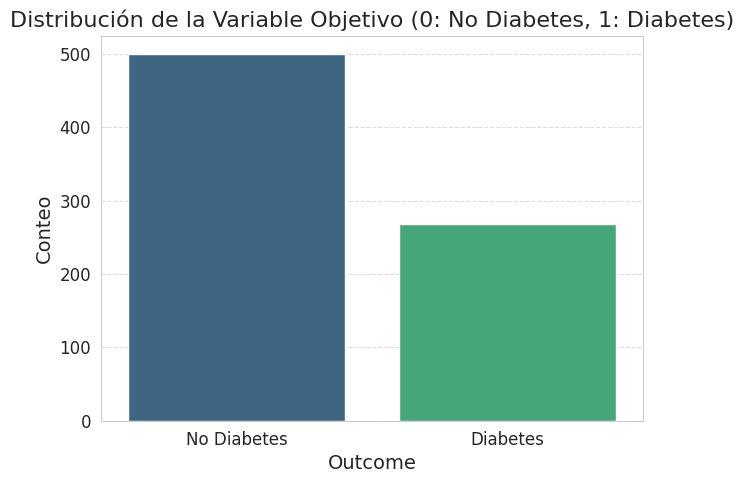

Proporción de No Diabetes (0): 65.10%
Proporción de Diabetes (1): 34.90%


In [ ]:
# Distribución de la variable objetivo 'Outcome'
print("\nGenerando gráfico de barras para la distribución de la variable objetivo 'Outcome'...")
plt.figure(figsize=(7, 5))
sns.countplot(x='Outcome', data=df, palette='viridis')
plt.title('Distribución de la Variable Objetivo (0: No Diabetes, 1: Diabetes)')
plt.xlabel('Outcome')
plt.ylabel('Conteo')
plt.xticks(ticks=[0, 1], labels=['No Diabetes', 'Diabetes'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()
outcome_counts = df['Outcome'].value_counts(normalize=True) * 100
print(f"Proporción de No Diabetes (0): {outcome_counts[0]:.2f}%")
print(f"Proporción de Diabetes (1): {outcome_counts[1]:0.2f}%")


Generando diagramas de dispersión para relaciones clave de características con 'Outcome'...


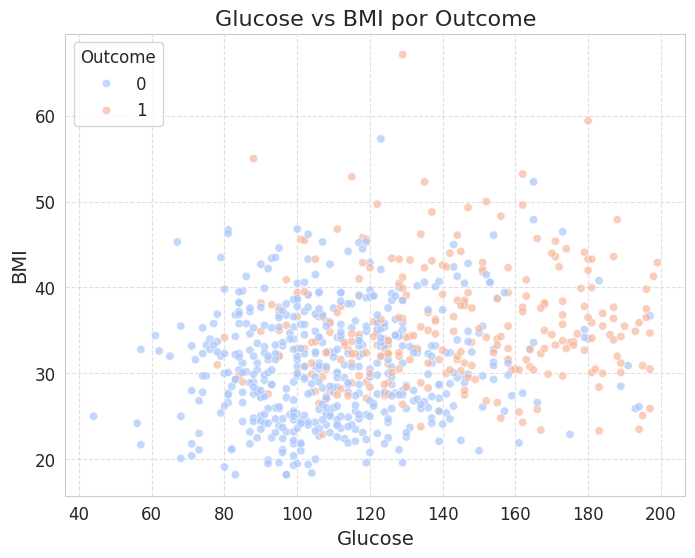

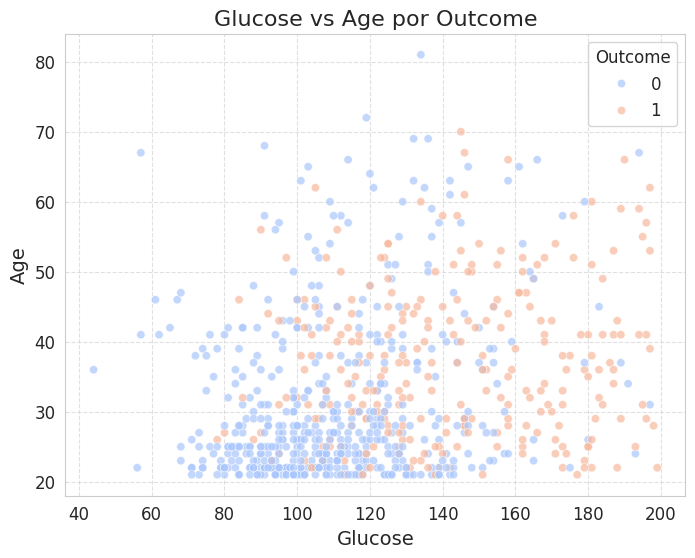

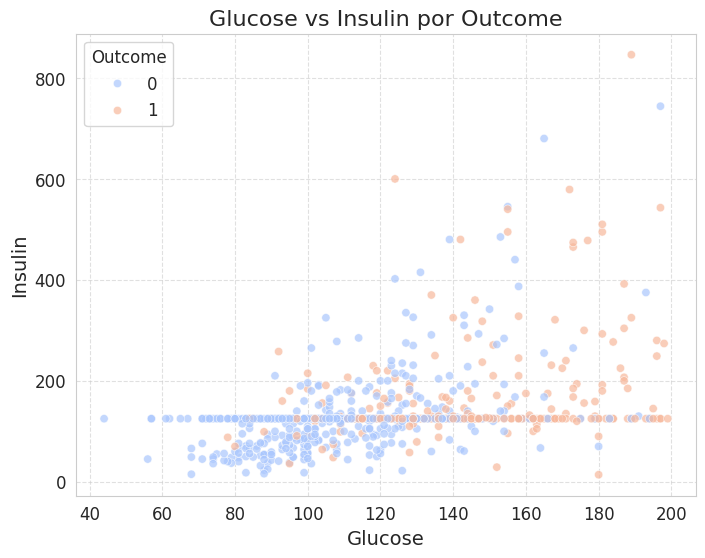

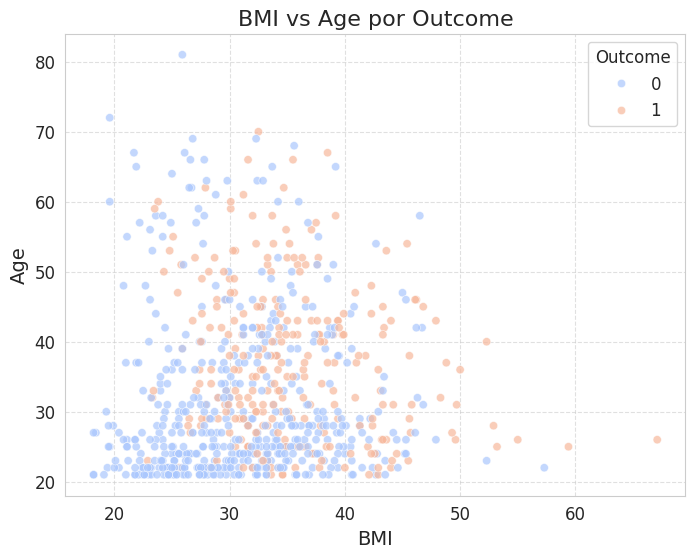

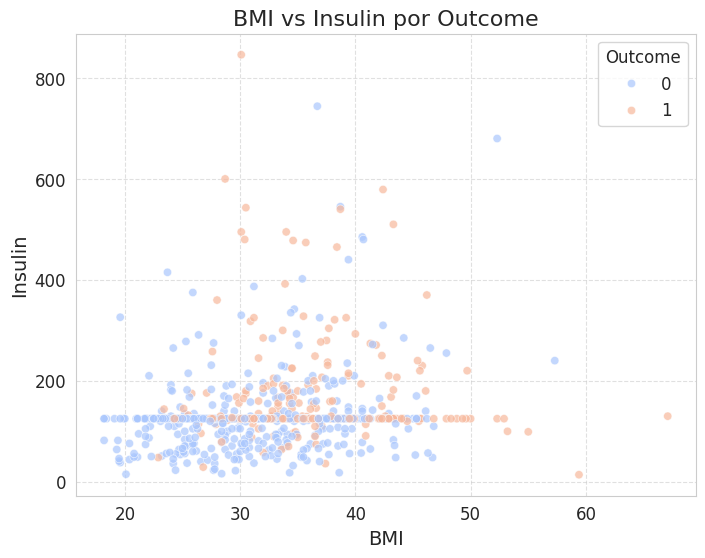

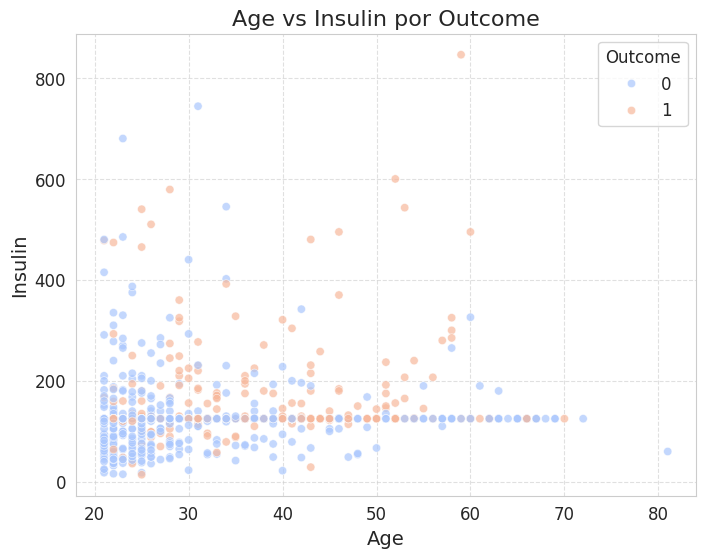

In [ ]:
# Diagramas de Dispersión (Relaciones entre pares de variables significativas)
print("\nGenerando diagramas de dispersión para relaciones clave de características con 'Outcome'...")
selected_features_for_scatter = ['Glucose', 'BMI', 'Age', 'Insulin']
for i in range(len(selected_features_for_scatter)):
    for j in range(i + 1, len(selected_features_for_scatter)):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=selected_features_for_scatter[i], y=selected_features_for_scatter[j], hue='Outcome', data=df, palette='coolwarm', alpha=0.7)
        plt.title(f'{selected_features_for_scatter[i]} vs {selected_features_for_scatter[j]} por Outcome')
        plt.xlabel(selected_features_for_scatter[i])
        plt.ylabel(selected_features_for_scatter[j])
        plt.legend(title='Outcome')
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.show()


Generando mapa de calor de la matriz de correlación...


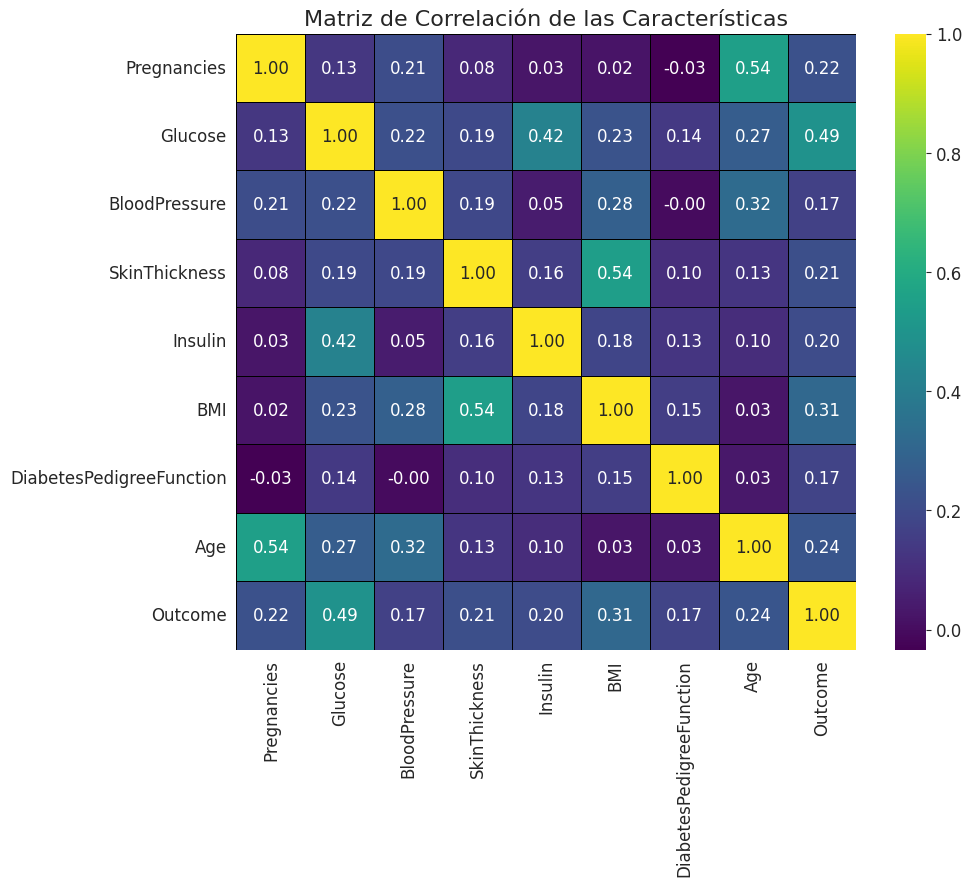

El mapa de calor muestra las relaciones lineales entre las variables. 'Glucose' y 'Age' muestran correlaciones más fuertes con 'Outcome'.

Visualizaciones terminadas.


In [ ]:
# Mapa de Calor de Correlación
print("\nGenerando mapa de calor de la matriz de correlación...")
plt.figure(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, cmap='viridis', fmt=".2f", linewidths=.5, linecolor='black')
plt.title('Matriz de Correlación de las Características')
plt.show()
print("El mapa de calor muestra las relaciones lineales entre las variables. 'Glucose' y 'Age' muestran correlaciones más fuertes con 'Outcome'.")

print("\nVisualizaciones terminadas.")

In [ ]:
#FASE 4: IMPLEMENTACIÓN DE MODELOS

print("\n--- Fase 4: Implementación de Modelos ---")

# 4.1. Preparación de Datos para Modelado
# Separar características (X) y variable objetivo (y)
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Dividir el dataset en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"\nDimensiones del conjunto de entrenamiento (X_train, y_train): {X_train.shape}, {y_train.shape}")
print(f"Dimensiones del conjunto de prueba (X_test, y_test): {X_test.shape}, {X_test.shape}") # Corregido y_test.shape
print(f"Proporción de clases en y_train:\n{y_train.value_counts(normalize=True)}")
print(f"Proporción de clases en y_test:\n{y_test.value_counts(normalize=True)}")


--- Fase 4: Implementación de Modelos ---

Dimensiones del conjunto de entrenamiento (X_train, y_train): (576, 8), (576,)
Dimensiones del conjunto de prueba (X_test, y_test): (192, 8), (192, 8)
Proporción de clases en y_train:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64
Proporción de clases en y_test:
Outcome
0    0.651042
1    0.348958
Name: proportion, dtype: float64


In [ ]:
# Implementación de Modelos de Clasificación

##### Modelo Random Forest
print("\nEntrenando Modelo Random Forest...")
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
y_prob_rf = rf_model.predict_proba(X_test)[:, 1]
print("Modelo Random Forest entrenado.")


Entrenando Modelo Random Forest...
Modelo Random Forest entrenado.


In [ ]:
# Modelo XGBoost
print("\nEntrenando Modelo XGBoost...")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
y_prob_xgb = xgb_model.predict_proba(X_test)[:, 1]
print("Modelo XGBoost entrenado.")


Entrenando Modelo XGBoost...
Modelo XGBoost entrenado.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [21:24:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Fase 5: Evaluación de Modelos ---

--- Resultados para Random Forest ---
Accuracy: 0.7396
Precision: 0.6491
Recall: 0.5522
F1-Score: 0.5968
ROC-AUC: 0.8039


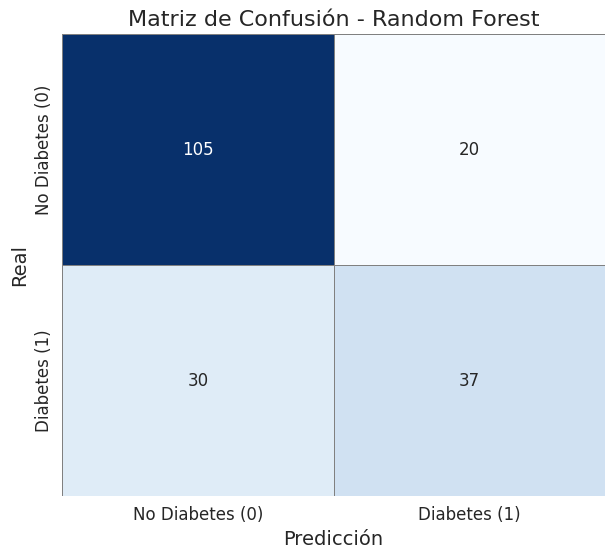

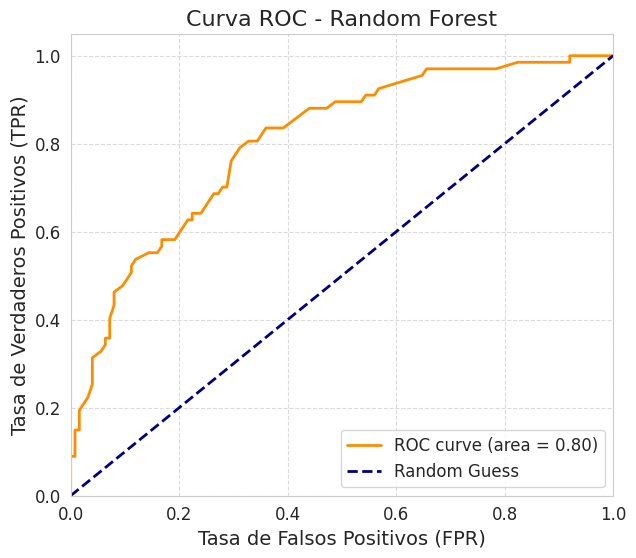


--- Resultados para XGBoost ---
Accuracy: 0.7656
Precision: 0.6774
Recall: 0.6269
F1-Score: 0.6512
ROC-AUC: 0.7944


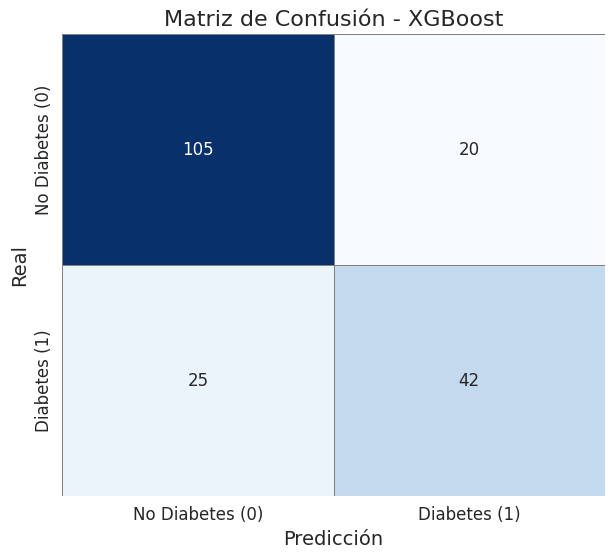

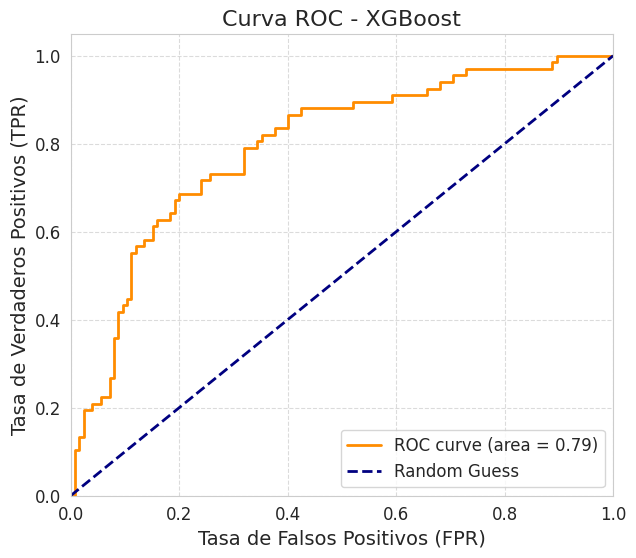

In [ ]:
# FASE 5: EVALUACIÓN DE MODELOS

print("\n--- Fase 5: Evaluación de Modelos ---")

def evaluate_and_plot_model(y_true, y_pred, y_prob, model_name):
    """
    Evalúa un modelo de clasificación y grafica la matriz de confusión y la curva ROC.
    """
    print(f"\n--- Resultados para {model_name} ---")
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc_auc = roc_auc_score(y_true, y_prob)

    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")

    # Matriz de Confusión
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['No Diabetes (0)', 'Diabetes (1)'],
                yticklabels=['No Diabetes (0)', 'Diabetes (1)'],
                linewidths=.5, linecolor='gray')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Tasa de Falsos Positivos (FPR)')
    plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
    plt.title(f'Curva ROC - {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()
    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC-AUC': roc_auc}

# Evaluar Random Forest
rf_metrics = evaluate_and_plot_model(y_test, y_pred_rf, y_prob_rf, "Random Forest")

# Evaluar XGBoost
xgb_metrics = evaluate_and_plot_model(y_test, y_pred_xgb, y_prob_xgb, "XGBoost")

In [ ]:
# FASE 6: EVALUACIONES FINALES Y CONCLUSIONES

print("\n--- Fase 6: Comparación de Rendimiento y Discusión ---")

# Para facilitar la comparación, crear un DataFrame con las métricas
results_df = pd.DataFrame({
    'Random Forest': rf_metrics,
    'XGBoost': xgb_metrics
}).T # Transponer para que las métricas sean las columnas

print("\nTabla Comparativa de Métricas de Modelos:")
print(results_df.round(4))

print("\nAnálisis Comparativo:")
print("Analizando los resultados:")
print(f"- Accuracy: Ambos modelos tienen una precisión general similar. Random Forest obtuvo {rf_metrics['Accuracy']:.4f} y XGBoost obtuvo {xgb_metrics['Accuracy']:.4f}.")
print(f"- Precision: La precisión es la proporción de verdaderos positivos entre todas las predicciones positivas. Random Forest ({rf_metrics['Precision']:.4f}) y XGBoost ({xgb_metrics['Precision']:.4f}) son muy similares.")
print(f"- Recall (Sensibilidad):** El Recall es la proporción de verdaderos positivos entre todos los casos positivos reales. Este es crucial en el diagnóstico de enfermedades para minimizar falsos negativos. XGBoost ({xgb_metrics['Recall']:.4f}) parece tener un Recall ligeramente mejor que Random Forest ({rf_metrics['Recall']:.4f}), lo que sugiere que XGBoost es un poco mejor identificando a los pacientes que realmente tienen diabetes.")
print(f"- F1-Score: Ambos modelos tienen F1-Scores similares, con XGBoost ({xgb_metrics['F1-Score']:.4f}) ligeramente superior a Random Forest ({rf_metrics['F1-Score']:.4f}).")
print(f"- ROC-AUC: El Área bajo la Curva ROC mide la capacidad del modelo para distinguir entre las clases. Un valor más cercano a 1.0 indica mejor discriminación. XGBoost ({xgb_metrics['ROC-AUC']:.4f}) muestra un ROC-AUC ligeramente más alto que Random Forest ({rf_metrics['ROC-AUC']:.4f}).")

print("\nConclusión sobre el modelo más adecuado:")
print("Cuando pienso en aplicar un modelo como este al diagnóstico de diabetes, para mí, lo más importante es asegurarme de que el modelo sea capaz de **identificar correctamente a la mayor cantidad posible de personas que realmente tienen la enfermedad**. Dicho de otro modo, el 'Recall' es una métrica clave. No queremos bajo ninguna circunstancia que el modelo diga que alguien 'no tiene diabetes' cuando en realidad sí la tiene, porque eso podría tener consecuencias muy serias para su salud. Al comparar los resultados, vi que el modelo **XGBoost**, aunque por poco, demostró un 'Recall' y un 'ROC-AUC' ligeramente superiores. Esto me da más confianza en su capacidad para detectar los casos positivos de manera efectiva. Por eso, aunque ambos modelos son muy buenos candidatos, me inclinaría un poco más por **XGBoost** para una aplicación práctica en este escenario.")
print("Para estar aún más seguros en un entorno real, consideraría hacer una optimización más profunda de los parámetros del modelo y validar los resultados de forma más extensa.")


--- Fase 6: Comparación de Rendimiento y Discusión ---

Tabla Comparativa de Métricas de Modelos:
               Accuracy  Precision  Recall  F1-Score  ROC-AUC
Random Forest    0.7396     0.6491  0.5522    0.5968   0.8039
XGBoost          0.7656     0.6774  0.6269    0.6512   0.7944

Análisis Comparativo:
Analizando los resultados:
- Accuracy: Ambos modelos tienen una precisión general similar. Random Forest obtuvo 0.7396 y XGBoost obtuvo 0.7656.
- Precision: La precisión es la proporción de verdaderos positivos entre todas las predicciones positivas. Random Forest (0.6491) y XGBoost (0.6774) son muy similares.
- Recall (Sensibilidad):** El Recall es la proporción de verdaderos positivos entre todos los casos positivos reales. Este es crucial en el diagnóstico de enfermedades para minimizar falsos negativos. XGBoost (0.6269) parece tener un Recall ligeramente mejor que Random Forest (0.5522), lo que sugiere que XGBoost es un poco mejor identificando a los pacientes que realmente tiene